In [27]:
!python -m pip install prophet

In [28]:
!pip install xlsxwriter

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from prophet import Prophet
import os

# Load and preprocess data
years = ["2019", "2020", "2021", "2022", "2023"]
df = None
for year in years:
    _df = pd.read_excel("sales_by_day.xlsx", sheet_name=year)
    if df is None:
        df = _df
        continue
    df = pd.concat([df, _df])

# Melt the data to long format
df = df.melt(
    id_vars=["Номенклатура"],
    var_name="ds",
    value_name="y")

# Filter out summary rows
df = df[~df["ds"].str.contains("Общий итог", na=False)]
df = df[~df["Номенклатура"].str.contains("ИТОГО:", na=False)]

# Convert dates and numeric values
df["ds"] = pd.to_datetime(df["ds"], format="%d.%m.%Y")
df["y"] = df["y"].astype(str).str.replace(" ", "").str.replace(",", ".").astype(float)

# Fill NA values with mean value for each product on the same day of year
df['month_day'] = df['ds'].dt.strftime('%m-%d')
mean_values = df.groupby(['Номенклатура', 'month_day'])['y'].transform('mean')
df['y'] = df['y'].fillna(mean_values)

# Fill remaining NAs with product's overall mean
product_means = df.groupby('Номенклатура')['y'].transform('mean')
df['y'] = df['y'].fillna(product_means)
df['y'] = df['y'].fillna(0)

# Get all unique products
all_products = df["Номенклатура"].unique()
print(f"Generating forecasts for {len(all_products)} products")

# Create a single large DataFrame to hold all forecasts
# First, generate all dates for 2024
dates_2024 = pd.date_range(start=datetime(2024, 1, 1), end=datetime(2024, 12, 31), freq='D')
date_columns = [date.strftime('%d.%m.%Y') for date in dates_2024]

# Create empty DataFrame with products as rows and dates as columns
forecast_matrix = pd.DataFrame(index=all_products, columns=date_columns)
forecast_matrix.index.name = "Номенклатура"

# Loop through each product
for i, product_name in enumerate(all_products):
    try:
        # Filter data for this product
        product_data = df[df["Номенклатура"] == product_name].copy()

        if len(product_data) == 0:
            print(f"No data found for product: {product_name}")
            continue

        # Prepare data for Prophet
        prophet_data = product_data[["ds", "y"]].copy()
        prophet_data = prophet_data.sort_values("ds")

        # Create and fit Prophet model
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        model.fit(prophet_data)

        # Create future dataframe for 2024
        future = model.make_future_dataframe(periods=366)  # Account for leap year
        # Filter to just get 2024
        future = future[future["ds"].dt.year == 2024]

        # Make predictions
        forecast = model.predict(future)

        # Add forecasted values to the matrix
        for _, row in forecast.iterrows():
            date = row["ds"]
            if date.year == 2024:
                date_str = date.strftime('%d.%m.%Y')
                # Use yhat (the forecast) rather than original data
                forecast_matrix.loc[product_name, date_str] = max(0, row["yhat"])  # Ensure no negative values

        # Progress indicator
        if (i+1) % 10 == 0 or (i+1) == len(all_products):
            print(f"Processed {i+1}/{len(all_products)} products")

    except Exception as e:
        print(f"Error processing product '{product_name}': {e}")

# Add "Общий итог" (Grand Total) column for each product
forecast_matrix["Общий итог"] = forecast_matrix.sum(axis=1)

# Reset index to make "Номенклатура" a regular column
forecast_matrix = forecast_matrix.reset_index()

# Save the final DataFrame to Excel
forecast_matrix.to_excel("forecasts_2024_v2.xlsx", index=False)
print("All forecasts saved to forecasts_2024.xlsx")

<ipython-input-30-db25ecd9256f>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/ojqz9ldo.json


Generating forecasts for 25 products


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/upkeurb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98681', 'data', 'file=/tmp/tmp1yftlrd1/ojqz9ldo.json', 'init=/tmp/tmp1yftlrd1/upkeurb4.json', 'output', 'file=/tmp/tmp1yftlrd1/prophet_modelp6iwepsj/prophet_model-20250512065625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/hdraaa3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/ssp7g0k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Processed 10/25 products


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/0_bmibsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79907', 'data', 'file=/tmp/tmp1yftlrd1/v8t9hg_n.json', 'init=/tmp/tmp1yftlrd1/0_bmibsj.json', 'output', 'file=/tmp/tmp1yftlrd1/prophet_modeloc3lr5bj/prophet_model-20250512065659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/nh5v9vzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/j95b2hn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

Processed 20/25 products


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/8a4toktt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/01tqafk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60647', 'data', 'file=/tmp/tmp1yftlrd1/8a4toktt.json', 'init=/tmp/tmp1yftlrd1/01tqafk0.json', 'output', 'file=/tmp/tmp1yftlrd1/prophet_modelooaf_dwr/prophet_model-20250512065720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/5u6enfib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/w9u819gp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Processed 25/25 products
All forecasts saved to forecasts_2024.xlsx


In [17]:
import pandas as pd
from prophet import Prophet

years = ["2019", "2020", "2021", "2022", "2023"]
df = None

# Load and concatenate all data
for year in years:
    _df = pd.read_excel("sales_by_day.xlsx", sheet_name=year)
    if df is None:
        df = _df
        continue
    df = pd.concat([df, _df])

# Melt the data to long format
df = df.melt(
    id_vars=["Номенклатура"],
    var_name="ds",
    value_name="y"
)

# Filter out summary rows
df = df[~df["ds"].str.contains("Общий итог", na=False)]
df = df[~df["Номенклатура"].str.contains("ИТОГО:", na=False)]

# Convert dates and numeric values
df["ds"] = pd.to_datetime(df["ds"], format="%d.%m.%Y")
df["y"] = df["y"].astype(str).str.replace(" ", "").str.replace(",", ".").astype(float)

# Now let's fill NA values with mean value for each product on the same day of year
# Create new columns for grouping by same date across years
df['month_day'] = df['ds'].dt.strftime('%m-%d')  # Month and day

# Group by product and month_day to calculate means
mean_values = df.groupby(['Номенклатура', 'month_day'])['y'].transform('mean')

# Fill NA values with these means
df['y'] = df['y'].fillna(mean_values)

# If there are still NAs (if a product had no sales on that day across all years),
# we can fill remaining NAs with 0 or the product's overall mean
remaining_nas = df['y'].isna().sum()
if remaining_nas > 0:
    # Option 1: Fill with product's overall mean
    product_means = df.groupby('Номенклатура')['y'].transform('mean')
    df['y'] = df['y'].fillna(product_means)

    # If there are still NAs (new products with no history), fill with 0
    df['y'] = df['y'].fillna(0)

# Drop helper column if not needed anymore
df = df.drop('month_day', axis=1)

# Show the result
df

,Номенклатура,ds,y
0,00. ВОДА 19 литров,2019-01-02,3.000000
1,01. ВОДА 3 - 12л + Кулерная,2019-01-02,647.706654
2,"02. ВОДА 0,25 - 2,5л",2019-01-02,1432.501657
3,"03. НАПИТКИ, СОКИ, КВАС",2019-01-02,76.024848
4,04. ДИСТИЛЛИРОВАННАЯ (Техническая вода),2019-01-02,128.270431
...,...,...,...
227619,51. ПОДАРОЧНЫЕ СЕРТИФИКАТЫ,2023-12-31,2.090909
227620,52. УСЛУГИ,2023-12-31,64.000000
227621,77. АКЦИИ от Маркетинга!!!!!!!!!!!!!!,2023-12-31,97.638736
227622,88. ИНВЕНТАРЬ,2023-12-31,342.390838


In [18]:
some_product_data = df[df["Номенклатура"] == "00.   ВОДА 19 литров"][["ds", "y"]]
some_product_data

,ds,y
0,2019-01-02,3.000000
25,2019-01-02,4.000000
50,2019-01-02,4.000000
75,2019-01-02,4.000000
100,2019-01-02,4.000000
...,...,...
227500,2023-12-31,4582.865152
227525,2023-12-31,4582.865152
227550,2023-12-31,4582.865152
227575,2023-12-31,4582.865152


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/h5riunjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yftlrd1/v12r2lgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61860', 'data', 'file=/tmp/tmp1yftlrd1/h5riunjb.json', 'init=/tmp/tmp1yftlrd1/v12r2lgb.json', 'output', 'file=/tmp/tmp1yftlrd1/prophet_model68rq_sj9/prophet_model-20250512062258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


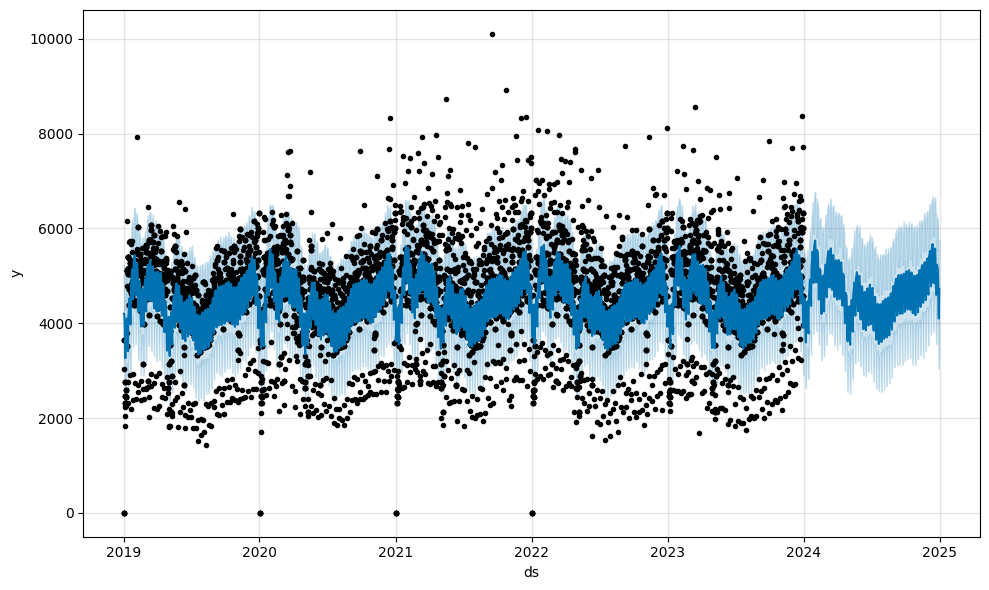

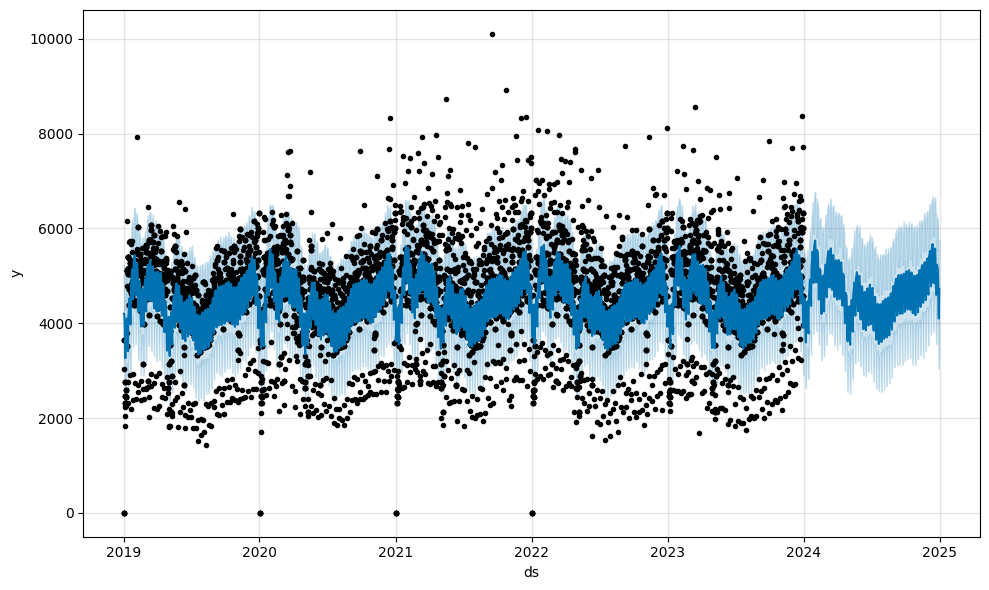

In [19]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(some_product_data)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

model.plot(forecast)

In [20]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [21]:
plot_components_plotly(model, forecast)

/usr/local/lib/python3.11/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [22]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,4331.227992,3243.468482,5239.454304,4331.227992,4331.227992,-131.907459,-131.907459,-131.907459,230.039063,230.039063,230.039063,-361.946523,-361.946523,-361.946523,0.0,0.0,0.0,4199.320533
1,2019-01-03,4332.849125,3160.581152,5178.954092,4332.849125,4332.849125,-143.054214,-143.054214,-143.054214,272.508010,272.508010,272.508010,-415.562224,-415.562224,-415.562224,0.0,0.0,0.0,4189.794911
2,2019-01-04,4334.470258,3003.345542,5035.850359,4334.470258,4334.470258,-348.062881,-348.062881,-348.062881,112.853528,112.853528,112.853528,-460.916408,-460.916408,-460.916408,0.0,0.0,0.0,3986.407377
3,2019-01-05,4336.091391,2333.591106,4486.261078,4336.091391,4336.091391,-914.371064,-914.371064,-914.371064,-417.394759,-417.394759,-417.394759,-496.976305,-496.976305,-496.976305,0.0,0.0,0.0,3421.720327
4,2019-01-06,4337.712524,2278.933701,4283.820868,4337.712524,4337.712524,-1074.747364,-1074.747364,-1074.747364,-551.875017,-551.875017,-551.875017,-522.872347,-522.872347,-522.872347,0.0,0.0,0.0,3262.965160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2024-12-26,4778.659979,4086.397329,6195.946217,4695.130867,4859.536480,372.187020,372.187020,372.187020,272.508010,272.508010,272.508010,99.679009,99.679009,99.679009,0.0,0.0,0.0,5150.846998
2181,2024-12-27,4778.939086,3872.155242,5835.681155,4695.018524,4860.620354,136.927602,136.927602,136.927602,112.853528,112.853528,112.853528,24.074074,24.074074,24.074074,0.0,0.0,0.0,4915.866688
2182,2024-12-28,4779.218194,3309.048885,5335.830550,4694.906180,4861.434870,-469.335466,-469.335466,-469.335466,-417.394759,-417.394759,-417.394759,-51.940706,-51.940706,-51.940706,0.0,0.0,0.0,4309.882728
2183,2024-12-29,4779.497302,3034.834593,5099.760558,4694.793837,4862.144982,-678.872375,-678.872375,-678.872375,-551.875017,-551.875017,-551.875017,-126.997359,-126.997359,-126.997359,0.0,0.0,0.0,4100.624926


In [23]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar


# Now let's generate a 2024 forecast for a specific product
# Replace with your specific product name
product_name = "00.   ВОДА 19 литров"  # Change this to your product name

# Filter data for this product
product_data = df[df["Номенклатура"] == product_name].copy()

if len(product_data) == 0:
    print(f"No data found for product: {product_name}")
    print("Available products:")
    print(df["Номенклатура"].unique())
else:
    # Create a calendar for 2024
    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 12, 31)

    # Generate all dates in 2024
    dates_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a DataFrame with these dates
    forecast_df = pd.DataFrame({'ds': dates_2024})

    # Add month-day column for matching
    product_data['month_day'] = product_data['ds'].dt.strftime('%m-%d')
    forecast_df['month_day'] = forecast_df['ds'].dt.strftime('%m-%d')

    # For each date in 2024, calculate the average from the same day in previous years
    # First get all unique month-day combinations with their average values
    day_avgs = product_data.groupby('month_day')['y'].mean().reset_index()

    # Merge with the 2024 dates
    forecast_df = forecast_df.merge(day_avgs, on='month_day', how='left')

    # Handle leap year (Feb 29) if it doesn't exist in historical data
    if forecast_df['y'].isna().any():
        # Use Feb 28 average for Feb 29
        feb28_avg = product_data[product_data['month_day'] == '02-28']['y'].mean()
        forecast_df.loc[forecast_df['month_day'] == '02-29', 'y'] = feb28_avg

    # Create a wide format DataFrame like the original Excel files
    wide_df = pd.DataFrame({'Номенклатура': [product_name]})

    # Format dates as in original Excel
    for date in forecast_df['ds']:
        date_str = date.strftime('%d.%m.%Y')
        wide_df[date_str] = forecast_df[forecast_df['ds'] == date]['y'].values[0]

    # Add "Общий итог" (Grand Total) column if desired
    wide_df["Общий итог"] = wide_df.iloc[:, 1:].sum(axis=1)

    # Save to Excel
    output_filename = f"{product_name}_forecast_2024.xlsx"
    wide_df.to_excel(output_filename, index=False, sheet_name="2024")
    print(f"Forecast saved to {output_filename}")

    # To see a preview of the result
    print("\nPreview of the first few columns:")
    preview_cols = ['Номенклатура'] + list(wide_df.columns[1:6])  # Product name and first 5 days
    print(wide_df[preview_cols])

<ipython-input-23-94749088aa45>:77: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-23-94749088aa45>:77: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-23-94749088aa45>:77: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-23-94749088aa45>:77: PerformanceWarning:

Forecast saved to 00.   ВОДА 19 литров_forecast_2024.xlsx

Preview of the first few columns:
           Номенклатура  01.01.2024  02.01.2024  03.01.2024  04.01.2024  \
0  00.   ВОДА 19 литров         NaN         4.0      3655.8      2468.0   

   05.01.2024  
0      2313.8  
